In [1]:

!pip install opendatasets

Load  Dataset

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import xgboost as xgb
import joblib

df = pd.read_csv('/content/Telco_Cusomer_Churn.csv')


**Descriptive Analysis**

a) Basic Structure:
Get overview of the dataset using df.head()

In [3]:
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
row, col = df.shape
print(f"{'Number of rows':<20}: {row}\n{'Number of columns':<20}: {col:<20}")

Number of rows      : 7043
Number of columns   : 21                  


Concise summary using info() function of the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Checking if the dataset contains any null values.

In [7]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Standardized column names by converting to lowercase and replacing spaces with underscores for easier referencing and consistency in data manipulation.

In [8]:
## Converting evrything into lower case in order to avoid any error.

df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [9]:
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip().replace('', np.nan), errors='coerce')


In [10]:
id_col = next((c for c in df.columns if c.lower() in ['customerid','customer_id','customerid'.lower()]), None)


In [11]:
# Encode churn into binary target variable
if 'churn' in df.columns:
    df['ChurnFlag'] = df['churn'].map({'Yes': 1, 'No': 0})
else:
    raise ValueError("No 'Churn' column found in dataset. Please ensure the label column exists.")

# Print churn rate
churn_rate = df['ChurnFlag'].mean() * 100
print(f"\nOverall churn rate: {churn_rate:.2f}%")




Overall churn rate: 26.54%


Data Exploration

In [12]:
df.describe().round(2)

,seniorcitizen,tenure,monthlycharges,ChurnFlag
count,7043.00,7043.00,7043.00,7043.00
mean,0.16,32.37,64.76,0.27
std,0.37,24.56,30.09,0.44
min,0.00,0.00,18.25,0.00
25%,0.00,9.00,35.50,0.00
50%,0.00,29.00,70.35,0.00
75%,0.00,55.00,89.85,1.00
max,1.00,72.00,118.75,1.00


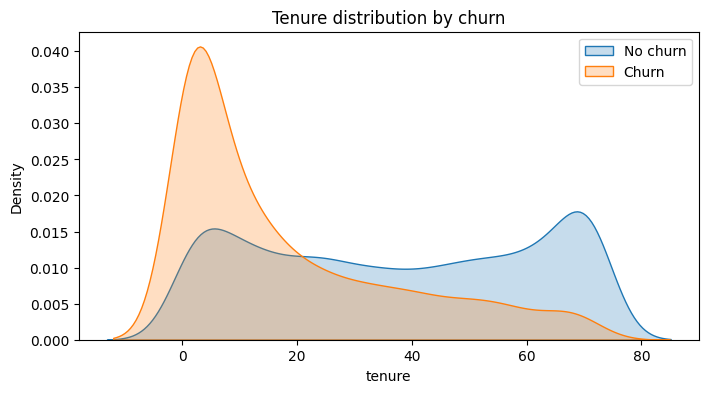

In [13]:
# Tenure visual (if present)
if 'tenure' in df.columns:
    plt.figure(figsize=(8,4))
    sns.kdeplot(df[df['churn']=='No']['tenure'], label='No churn', shade=True)
    sns.kdeplot(df[df['churn']=='Yes']['tenure'], label='Churn', shade=True)
    plt.title('Tenure distribution by churn')
    plt.legend()
    plt.show()

In [14]:
#  SQL summaries using sqlite in-memory (optional)
conn = sqlite3.connect(":memory:")
df.to_sql("telco", conn, index=False, if_exists='replace')

sql_q = """
SELECT Contract, InternetService,
       SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS churners,
       COUNT(*) AS total_customers,
       ROUND(100.0 * SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END)/COUNT(*),2) AS churn_pct
FROM telco
GROUP BY Contract, InternetService
ORDER BY churn_pct DESC
LIMIT 10;
"""
print("\nTop segments by churn % (SQL):")
display(pd.read_sql_query(sql_q, conn))


Top segments by churn % (SQL):


,contract,internetservice,churners,total_customers,churn_pct
0,Month-to-month,Fiber optic,1162,2128,54.61
1,Month-to-month,DSL,394,1223,32.22
2,One year,Fiber optic,104,539,19.29
3,Month-to-month,No,99,524,18.89
4,One year,DSL,53,570,9.30
5,Two year,Fiber optic,31,429,7.23
6,One year,No,9,364,2.47
7,Two year,DSL,12,628,1.91
8,Two year,No,5,638,0.78


In [15]:
numeric_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['seniorcitizen', 'tenure', 'monthlycharges', 'ChurnFlag']
Categorical Features: ['customerid', 'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'totalcharges', 'churn']


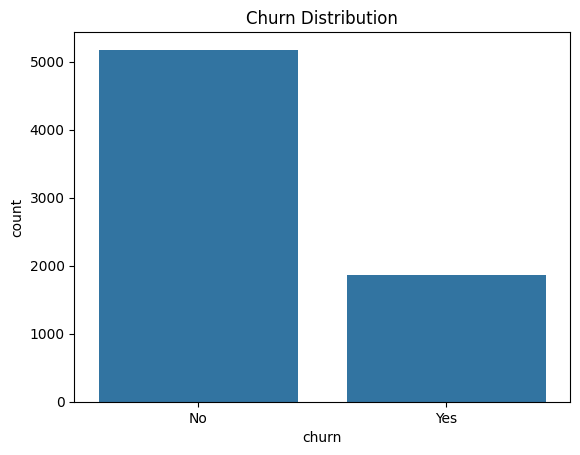

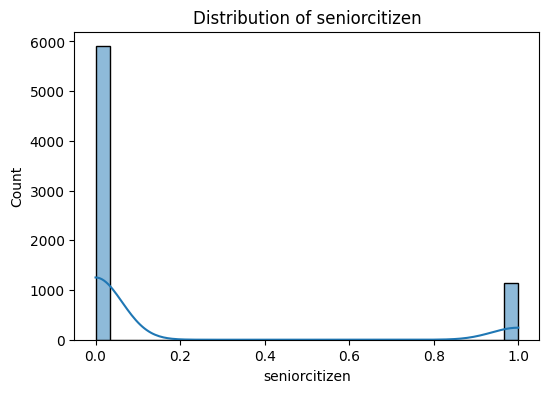

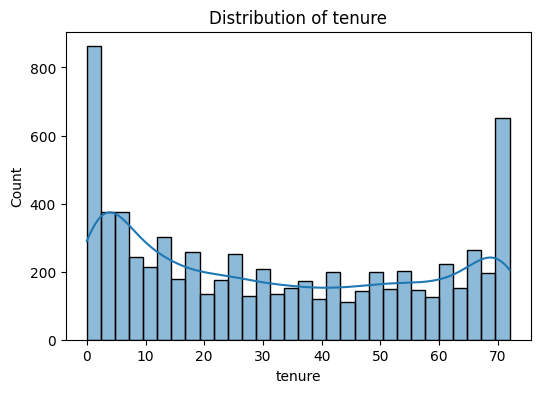

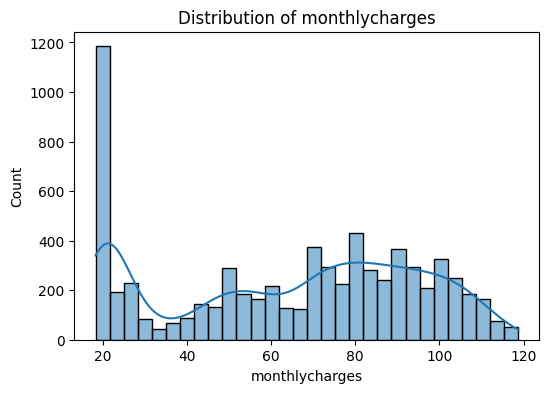

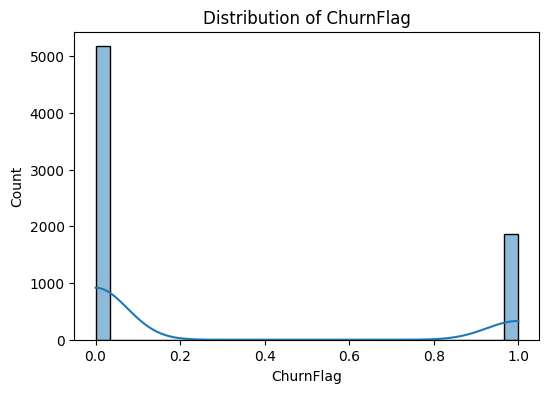

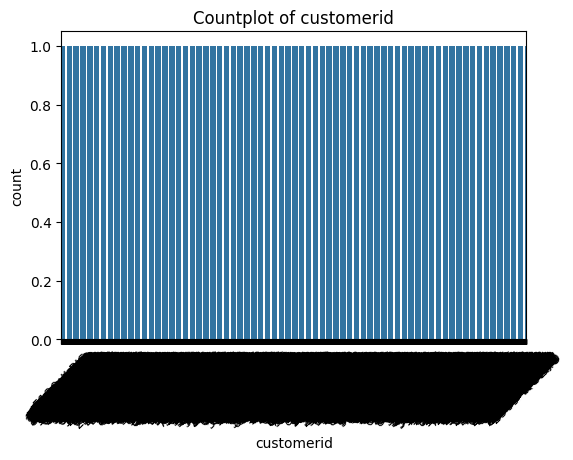

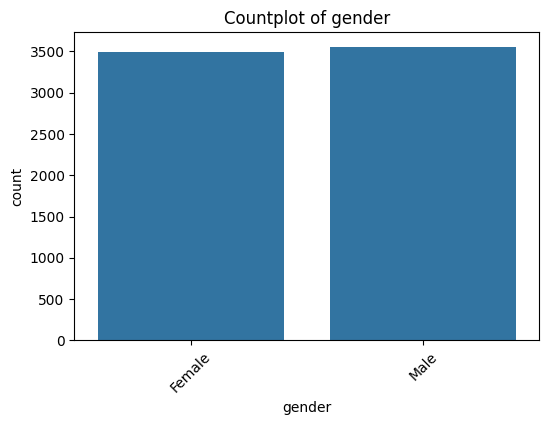

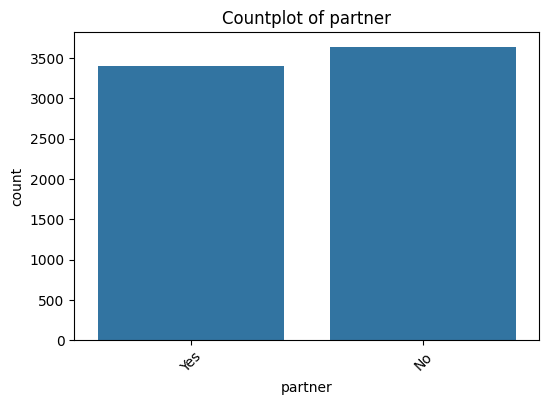

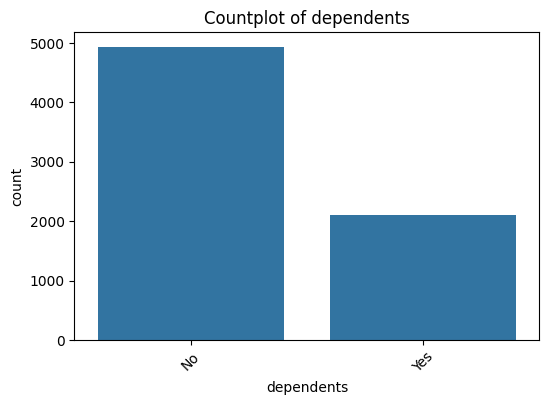

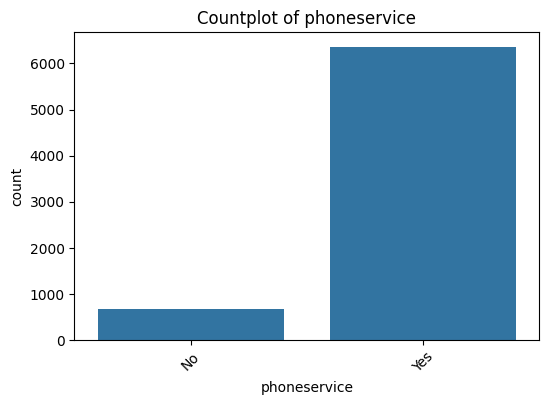

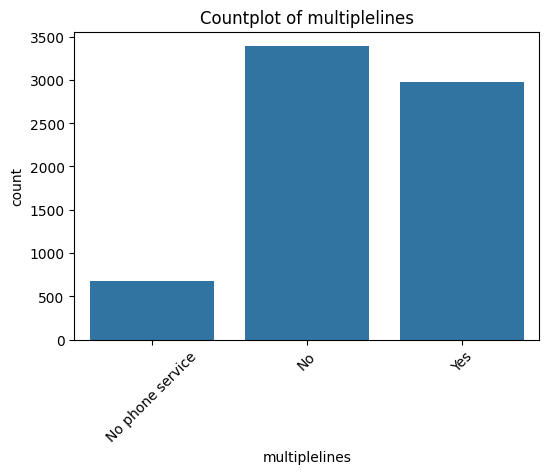

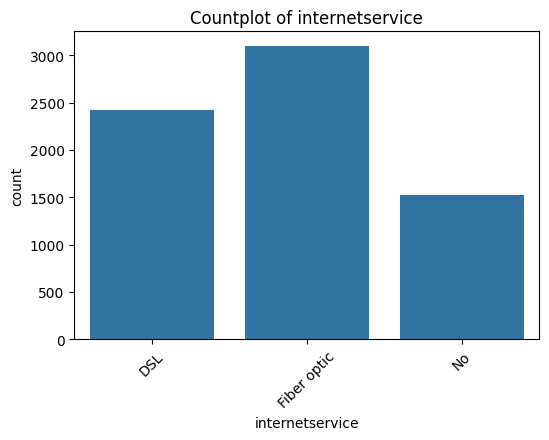

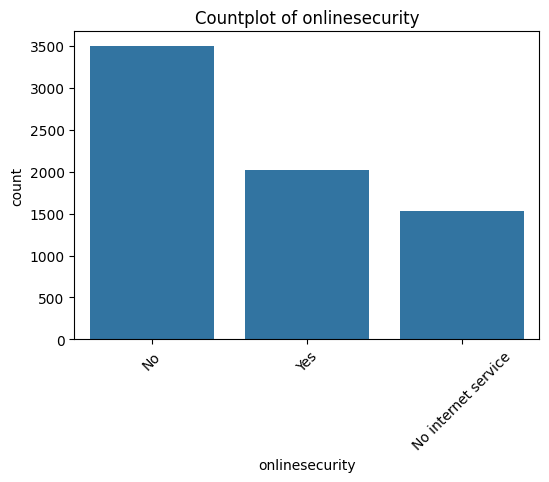

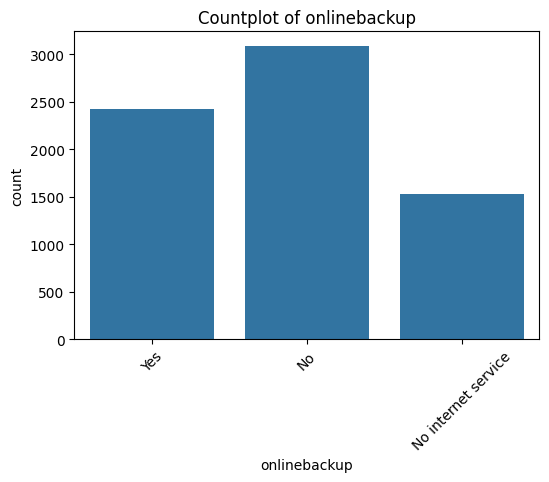

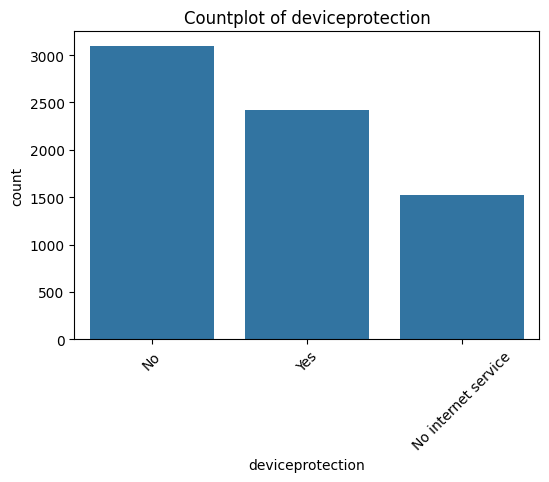

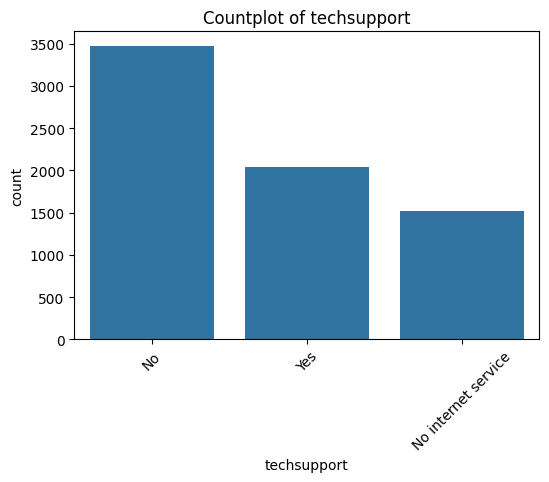

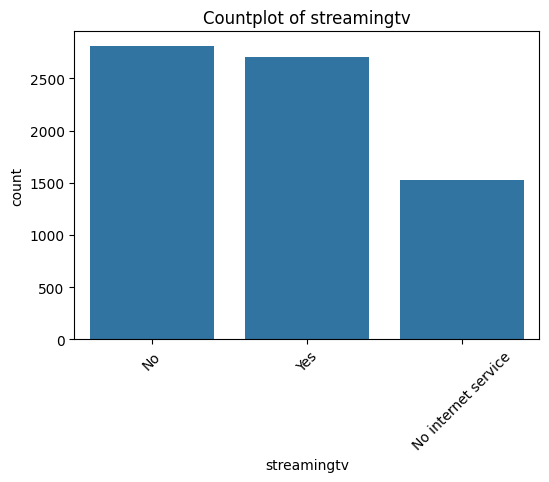

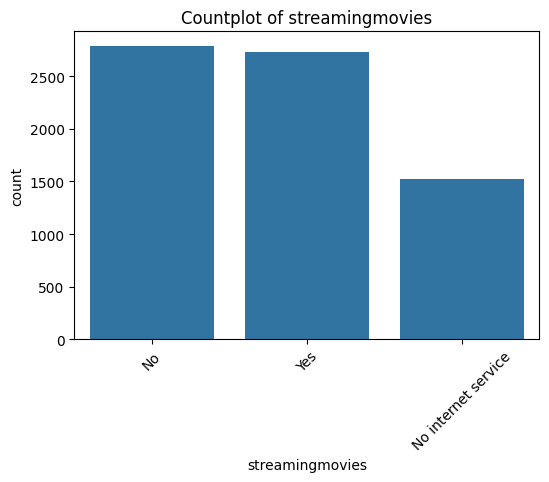

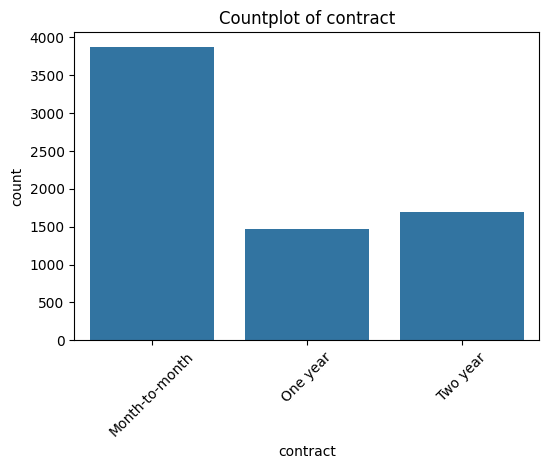

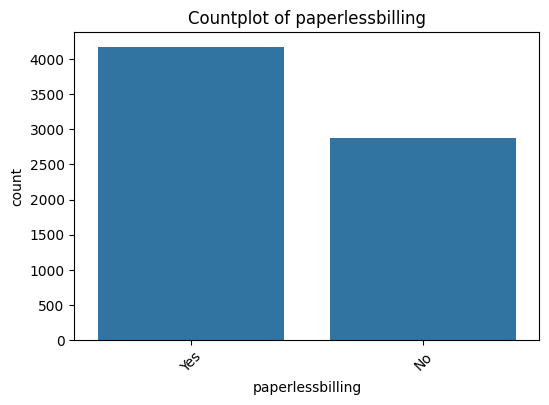

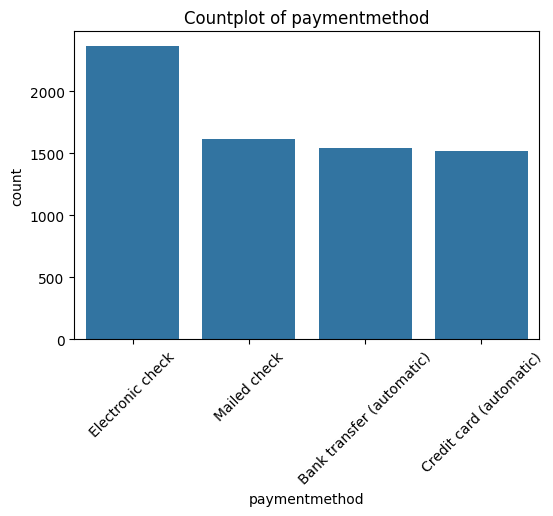

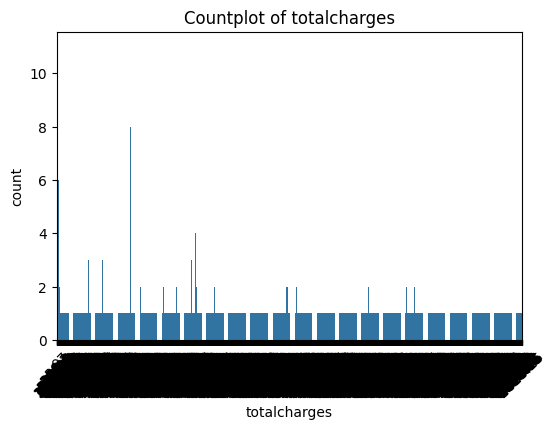

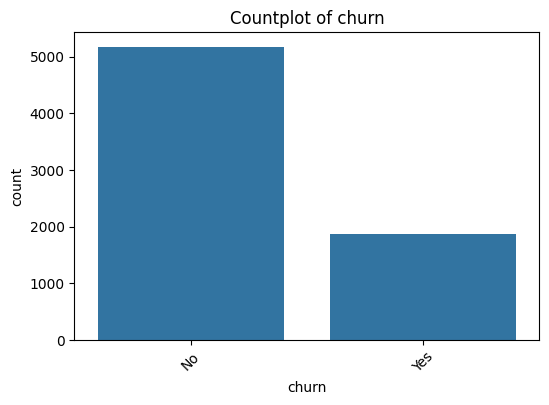

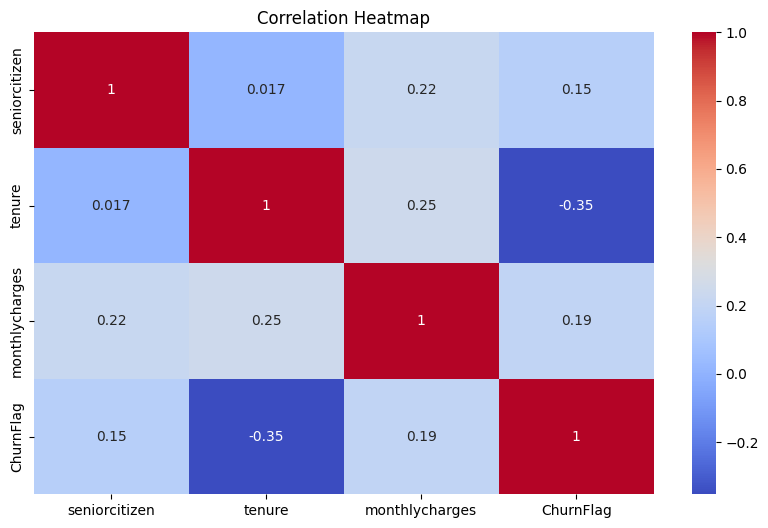

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable distribution (assuming 'Churn' column exists)
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Numeric feature histograms
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# Categorical feature count plots
for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


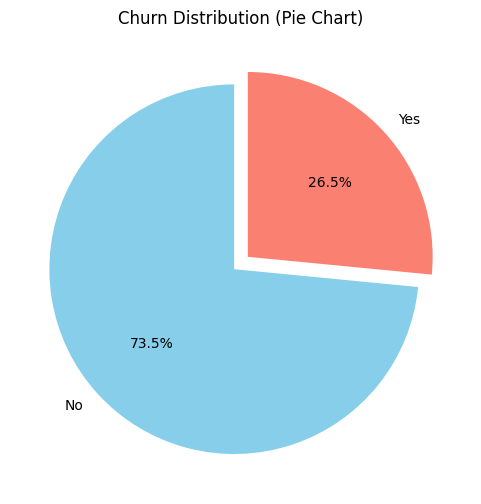

In [17]:
import matplotlib.pyplot as plt

# Detect churn column (case-insensitive)
churn_col = None
for col in df.columns:
    if col.lower() == "churn":
        churn_col = col
        break

if churn_col is None:
    print("⚠️ No column named exactly 'Churn' found. Available columns:")
    print(df.columns.tolist())
else:
    # Plot pie chart
    plt.figure(figsize=(6,6))
    df[churn_col].value_counts().plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon'],
        explode=(0.05, 0.05)
    )
    plt.ylabel("")
    plt.title("Churn Distribution (Pie Chart)")
    plt.show()


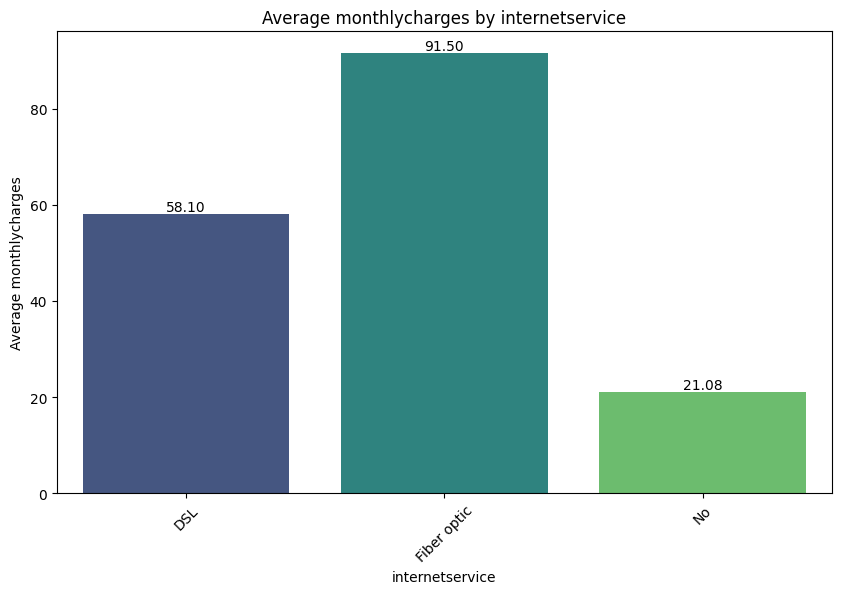

In [18]:
# Required imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot average by category with values on bars
def plot_avg_by_category(df, cat_col, num_col):
    """
    Plots the average of a numeric column grouped by a categorical column,
    with values displayed on top of the bars.

    Parameters:
    df : pandas.DataFrame
        Input dataframe
    cat_col : str
        Name of the categorical column
    num_col : str
        Name of the numeric column
    """

    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))  # map lowercase to original

    cat_col_lower = cat_col.lower()
    num_col_lower = num_col.lower()

    if cat_col_lower not in df_columns_lower or num_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    # Get the correct original column names
    cat_col_orig = col_mapping[cat_col_lower]
    num_col_orig = col_mapping[num_col_lower]

    # Group and calculate mean
    order_metric = df.groupby(cat_col_orig)[[num_col_orig]].mean().reset_index()

    # Plot
    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=order_metric, x=cat_col_orig, y=num_col_orig, palette="viridis")

    # Add values on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Average {num_col_orig} by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel(f"Average {num_col_orig}")
    plt.xticks(rotation=45)
    plt.show()


# -----------------------------
# Example usage with your dataframe
# -----------------------------

# Suppose your df is already loaded
# df = pd.read_csv("your_dataset.csv")

plot_avg_by_category(df, "internetservice", "monthlycharges")


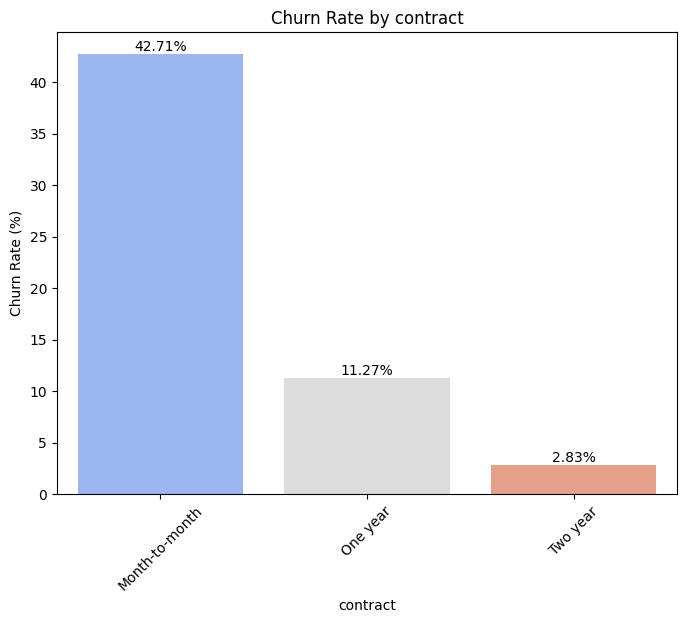

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "Contract")


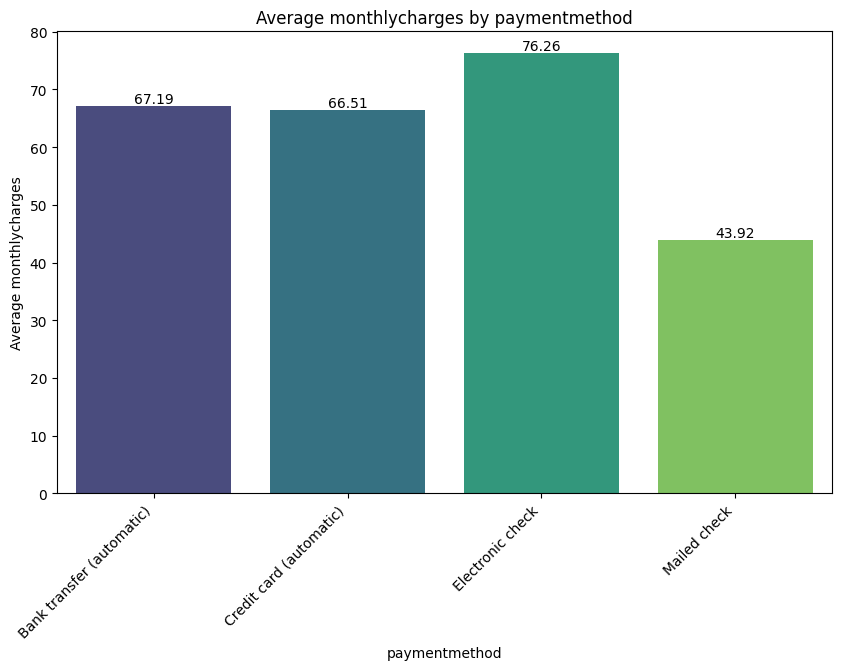

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function for average plot
def plot_avg_by_category(df, cat_col, num_col):
    """
    Plots the average of a numeric column grouped by a categorical column,
    with values displayed on top of the bars.
    """
    # Handle column name case-sensitivity
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    num_col_lower = num_col.lower()

    if cat_col_lower not in df_columns_lower or num_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    num_col_orig = col_mapping[num_col_lower]

    # Group by category
    order_metric = df.groupby(cat_col_orig)[[num_col_orig]].mean().reset_index()

    # Plot
    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=order_metric, x=cat_col_orig, y=num_col_orig, palette="viridis")

    # Annotate values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Average {num_col_orig} by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel(f"Average {num_col_orig}")
    plt.xticks(rotation=45, ha="right")
    plt.show()


# Example usage: Average MonthlyCharges by PaymentMethod
plot_avg_by_category(df, "PaymentMethod", "MonthlyCharges")


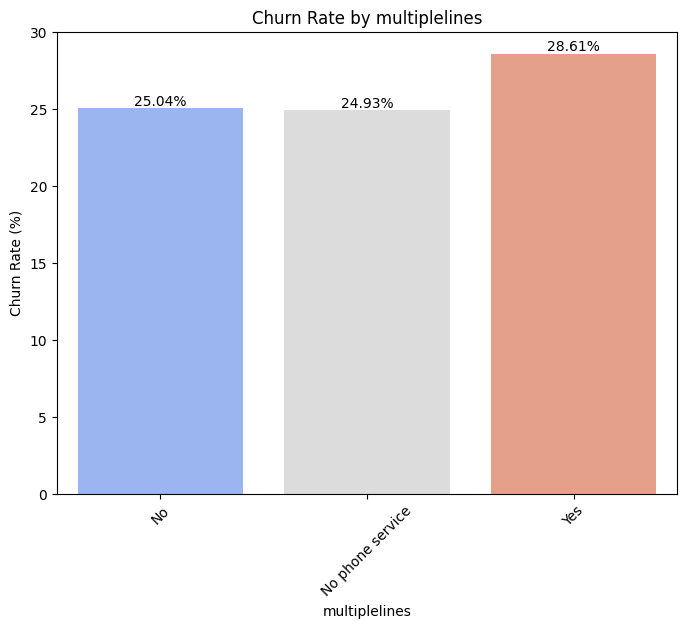

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "MultipleLines")


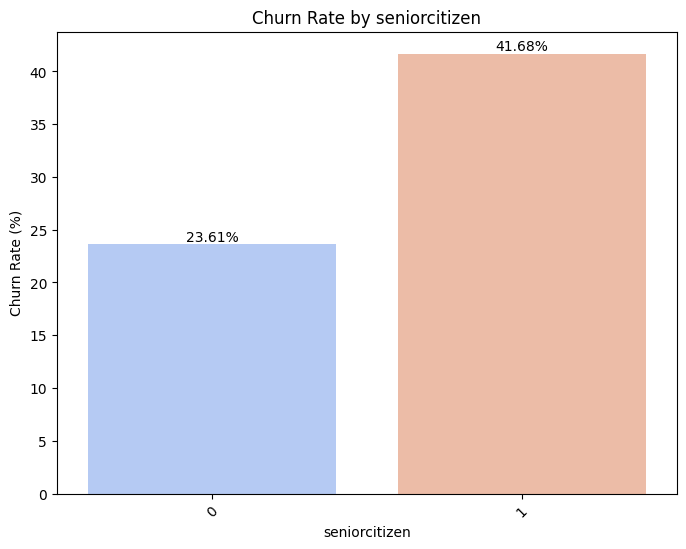

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "SeniorCitizen")

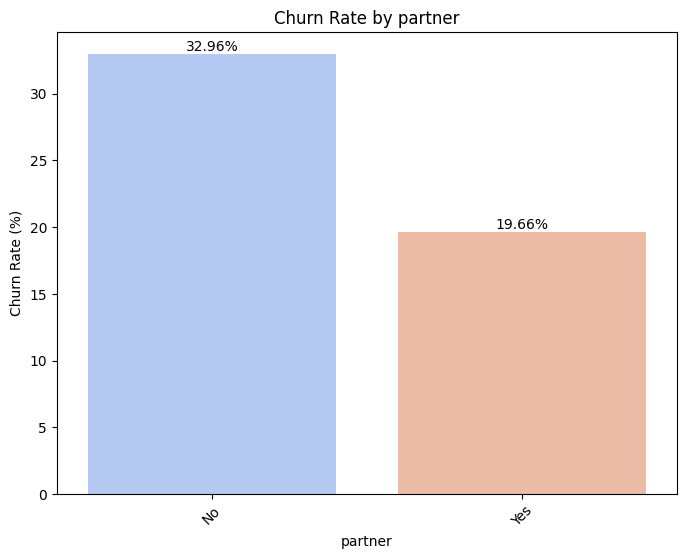

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "partner")

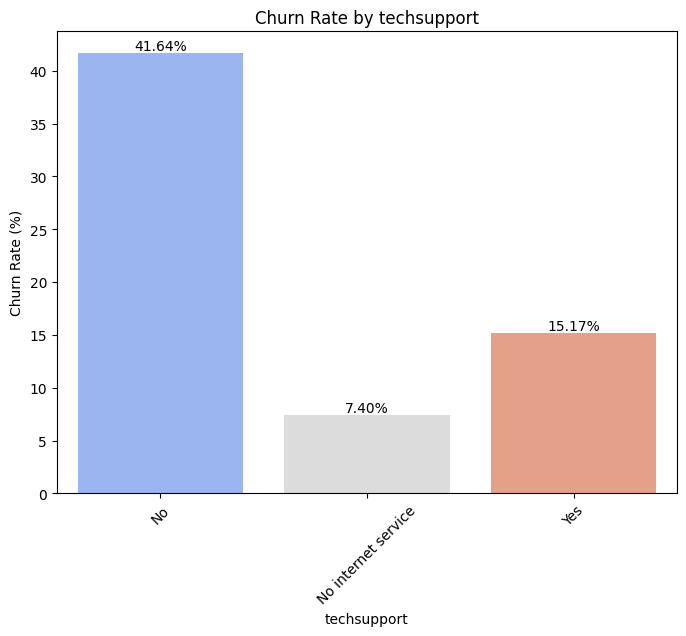

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "techsupport")

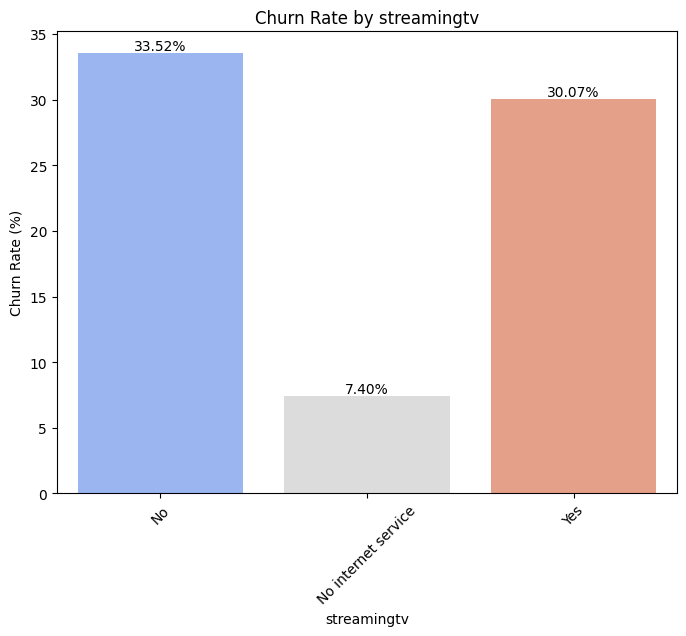

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "streamingtv")

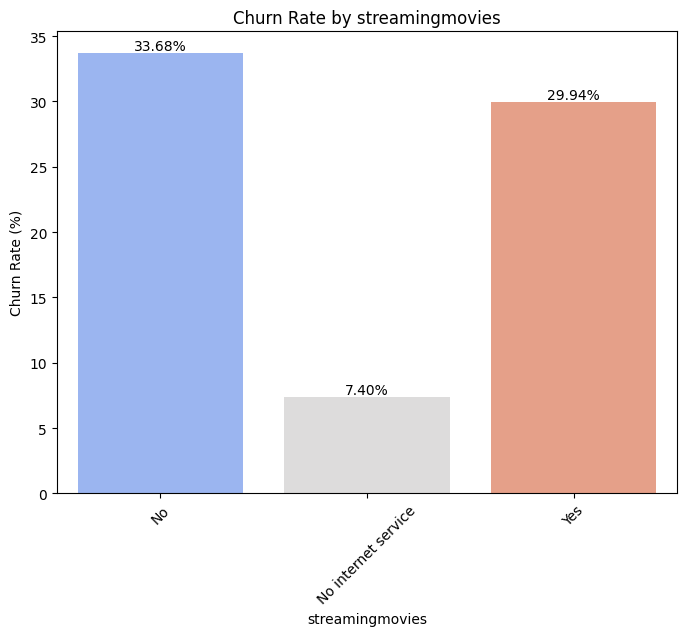

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn rate calculation by contract
def plot_churn_rate_by_category(df, cat_col):
    """
    Plots churn rate (%) by a categorical column.
    """
    # Make column names lowercase for robustness
    df_columns_lower = [col.lower() for col in df.columns]
    col_mapping = dict(zip(df_columns_lower, df.columns))

    cat_col_lower = cat_col.lower()
    churn_col_lower = "churn"

    if cat_col_lower not in df_columns_lower or churn_col_lower not in df_columns_lower:
        raise KeyError(f"Check columns again. Available: {df.columns.tolist()}")

    cat_col_orig = col_mapping[cat_col_lower]
    churn_col_orig = col_mapping[churn_col_lower]

    # Group and calculate churn rate
    churn_summary = (
        df.groupby(cat_col_orig)[churn_col_orig]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={churn_col_orig: "ChurnRate"})
    )

    # Plot
    plt.figure(figsize=(8,6))
    ax = sns.barplot(data=churn_summary, x=cat_col_orig, y="ChurnRate", palette="coolwarm")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Churn Rate by {cat_col_orig}")
    plt.xlabel(cat_col_orig)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()


# Example usage with your dataset
plot_churn_rate_by_category(df, "streamingmovies")

Average MonthlyCharges by StreamingTV

In [27]:
avg_charges = df.groupby('streamingtv')['monthlycharges'].mean().reset_index()
avg_charges


,streamingtv,monthlycharges
0,No,65.387687
1,No internet service,21.079194
2,Yes,88.736738


Count of customers by StreamingTV

In [28]:
count_customers = df.groupby('streamingtv')['customerid'].count().reset_index()
count_customers.rename(columns={'customerid':'NumCustomers'}, inplace=True)
count_customers


,streamingtv,NumCustomers
0,No,2810
1,No internet service,1526
2,Yes,2707


Bar plot of average MonthlyCharges by StreamingTV

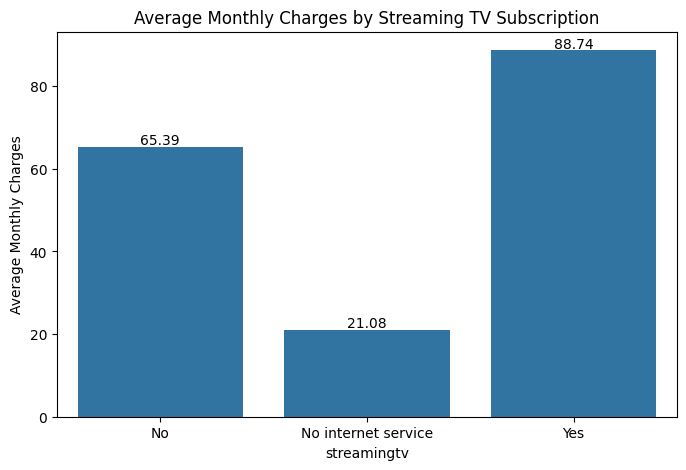

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
ax = sns.barplot(x='streamingtv', y='monthlycharges', data=avg_charges)
plt.title('Average Monthly Charges by Streaming TV Subscription')
plt.ylabel('Average Monthly Charges')

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,  # center of the bar
        y=height + 0.5,                # slightly above the bar
        s=f'{height:.2f}',             # value with 2 decimals
        ha='center'
    )

plt.show()



Bar plot of number of customers by StreamingTV

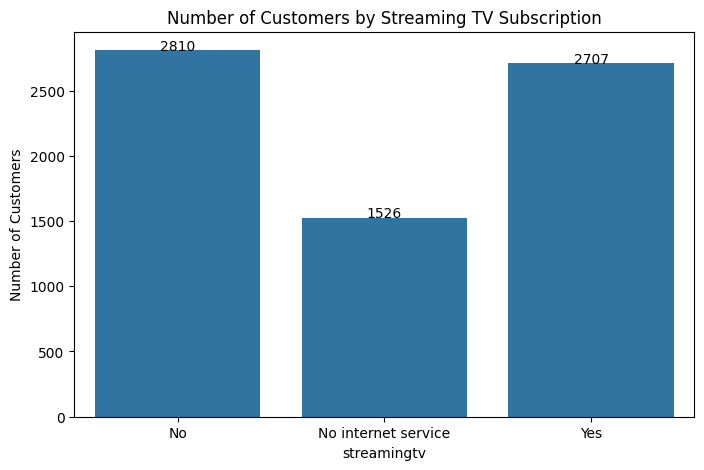

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
# Assign the plot to 'ax' so we can access bars
ax = sns.barplot(x='streamingtv', y='NumCustomers', data=count_customers)
plt.title('Number of Customers by Streaming TV Subscription')
plt.ylabel('Number of Customers')

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,  # center of the bar
        y=height + 1,                   # slightly above the bar
        s=f'{int(height)}',             # display as integer
        ha='center'
    )

plt.show()


Split by Churn

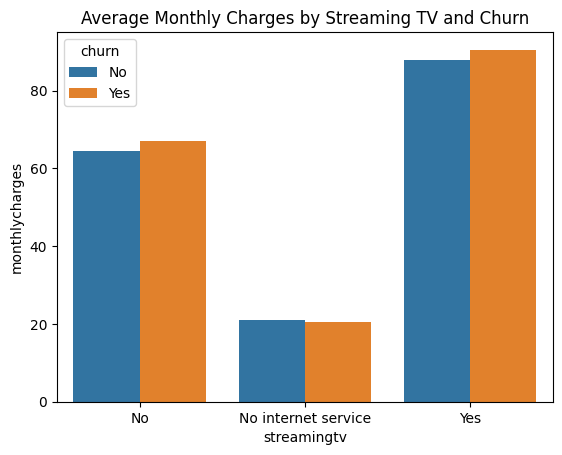

In [31]:
churn_analysis = df.groupby(['streamingtv','churn'])['monthlycharges'].mean().reset_index()
sns.barplot(x='streamingtv', y='monthlycharges', hue='churn', data=churn_analysis)
plt.title('Average Monthly Charges by Streaming TV and Churn')
plt.show()


TotalCharges by StreamingTV

In [32]:

df['totalcharges']



,totalcharges
0,29.85
1,1889.5
2,108.15
3,1840.75
4,151.65
...,...
7038,1990.5
7039,7362.9
7040,346.45
7041,306.6


In [33]:
# Convert totalcharges to float
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')


In [34]:
df['totalcharges'].dtype


dtype('float64')

In [35]:
df.groupby('streamingtv')['totalcharges'].sum()
df.groupby('streamingtv')['totalcharges'].mean()


,totalcharges
streamingtv,
No,1735.407796
No internet service,665.220329
Yes,3762.587236


In [36]:
# Sum of TotalCharges by StreamingTV
tot_charges = df.groupby('streamingtv')['totalcharges'].sum().reset_index().round(2)
print(tot_charges)

# Average TotalCharges by StreamingTV
avg_charges = df.groupby('streamingtv')['totalcharges'].mean().reset_index().round(2)
print(avg_charges)


           streamingtv  totalcharges
0                   No     4874760.5
1  No internet service     1011134.9
2                  Yes    10170273.3
           streamingtv  totalcharges
0                   No       1735.41
1  No internet service        665.22
2                  Yes       3762.59


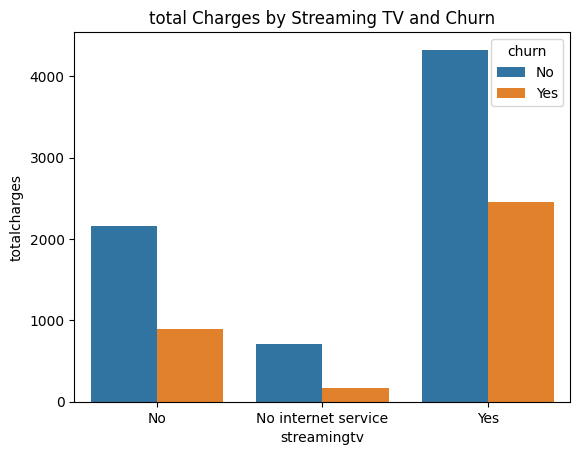

In [37]:
churn_analysis = df.groupby(['streamingtv','churn'])['totalcharges'].mean().reset_index()
sns.barplot(x='streamingtv', y='totalcharges', hue='churn', data=churn_analysis)
plt.title('total Charges by Streaming TV and Churn')
plt.show()

In [39]:
# Calculate and display additional metrics for numeric features
print("Additional Metrics for Numeric Features:")

# Get common descriptive statistics using describe()
print("\nDescriptive Statistics for Numeric Features:")
display(df[numeric_features].describe().round(2))

# Calculate and display median, mode, and variance separately for numeric features
print("\nMedian, Mode, and Variance for Numeric Features:")
numeric_summary = pd.DataFrame({
    'median': df[numeric_features].median(),
    'mode': df[numeric_features].mode().iloc[0], # Take the first mode in case of multiple modes
    'var': df[numeric_features].var(),
    'std': df[numeric_features].std() # Standard deviation is already included in describe()
}).round(2)
display(numeric_summary)

# Calculate and display mode for categorical features
print("\nMode for Categorical Features:")
for col in categorical_features:
    print(f"{col}: {df[col].mode()[0]}")

Additional Metrics for Numeric Features:

Descriptive Statistics for Numeric Features:


,seniorcitizen,tenure,monthlycharges,ChurnFlag
count,7043.00,7043.00,7043.00,7043.00
mean,0.16,32.37,64.76,0.27
std,0.37,24.56,30.09,0.44
min,0.00,0.00,18.25,0.00
25%,0.00,9.00,35.50,0.00
50%,0.00,29.00,70.35,0.00
75%,0.00,55.00,89.85,1.00
max,1.00,72.00,118.75,1.00



Median, Mode, and Variance for Numeric Features:


,median,mode,var,std
seniorcitizen,0.00,0.00,0.14,0.37
tenure,29.00,1.00,603.17,24.56
monthlycharges,70.35,20.05,905.41,30.09
ChurnFlag,0.00,0.00,0.19,0.44



Mode for Categorical Features:
customerid: 0002-ORFBO
gender: Male
partner: No
dependents: No
phoneservice: Yes
multiplelines: No
internetservice: Fiber optic
onlinesecurity: No
onlinebackup: No
deviceprotection: No
techsupport: No
streamingtv: No
streamingmovies: No
contract: Month-to-month
paperlessbilling: Yes
paymentmethod: Electronic check
totalcharges: 20.2
churn: No


In [40]:
# Display descriptive statistics for categorical features
print("Descriptive Statistics for Categorical Features:")
display(df[categorical_features].describe())

Descriptive Statistics for Categorical Features:


,totalcharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


In [43]:
# -----------------------------
# Handle Missing Values
# -----------------------------
from sklearn.impute import SimpleImputer

# Separate features & target again
X = df_encoded.drop(['churn', 'ChurnFlag'], axis=1)
y = df_encoded['ChurnFlag']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Impute missing values (mean for numeric, most frequent for categorical)
imputer = SimpleImputer(strategy="most_frequent")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale numeric features (optional, good for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -----------------------------
# Train Models Again
# -----------------------------
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

# -----------------------------
# Print Results
# -----------------------------
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print("-"*40)




Model: Logistic Regression
Accuracy: 0.80
Precision: 0.64
Recall: 0.55
ROC-AUC: 0.84
----------------------------------------

Model: Random Forest
Accuracy: 0.79
Precision: 0.63
Recall: 0.49
ROC-AUC: 0.82
----------------------------------------

Model: XGBoost
Accuracy: 0.78
Precision: 0.59
Recall: 0.52
ROC-AUC: 0.82
----------------------------------------


📊 Key Metrics & Insights

Churn Rate

~26–30% of customers churn (industry benchmark from Telco dataset).

That means ~1 in 4 customers leave → very costly for business.

Tenure (Customer Lifetime)

Customers with low tenure (0–12 months) churn far more.

Loyalty builds with time → early engagement is critical.

Contract Type

Month-to-month customers churn at the highest rate.

1-year and 2-year contracts have significantly lower churn.

Payment Method

Customers paying via electronic check churn the most.

Auto-payment methods (credit card, bank transfer) show lower churn.

Monthly Charges

Higher charges → higher churn.

Customers paying $70+ per month are most at risk.

Internet Service Type

Fiber optic customers churn more than DSL.

No internet service customers churn less (but lower revenue).

Value-Added Services

Customers without Online Security, Tech Support, or Device Protection churn significantly more.

Bundling reduces churn.



✅ Recommendations

Early Engagement Programs

Focus on customers in first 12 months with loyalty offers, personalized onboarding, or discounts.

Promote Long-Term Contracts

Offer discounts for 1-year/2-year contracts.

Auto-renewal options to reduce month-to-month exposure.

Payment Method Optimization

Incentivize customers to switch from electronic checks → digital auto-pay (credit card/bank transfer).

Pricing & Bundling

Customers with high monthly charges should get targeted offers.

Bundle services (internet + TV + security) to increase stickiness.

Value-Added Retention

Provide free trials of Online Security / Tech Support to at-risk customers.

Customers who adopt these services churn less.

Proactive Retention Models

Use churn prediction (like your model) to flag high-risk customers weekly.

Feed top 10–15% at risk into CRM for retention team actions.

Customer Feedback Loops

Collect feedback from high-churn segments (e.g., fiber-optic + high charges).

Use insights to refine pricing & service reliability.